# Predicting Breast Cancer in Wisconsin

This data set was donated by the University of Wisconsin Hospitals. We have diagnostic data about patients under the care of Dr. William Wolberg and whether masses found were malignant or benign. 

We will explore the data to understand the most significant identifying attributes of patients with malignant masses to give us a starting point for future research how to prevent malignant masses. We will create a model to predict malignant masses based on the diagnositic data provided.


In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn import tree
from sklearn.svm import SVC
%matplotlib inline
sns.set_style('white')

In [2]:
data = pd.read_csv('breast-cancer-wisconsin.csv', header=None)

In [3]:
#Give data names based on the text document
data.columns=['Sample_id','Clump_thick','Uni_cell_size','Uni_cell_shape'
             ,'Marg_adhesion','Epi_cell_size','Nuclei_bare','Chromatin_bland'
             ,'Nucleoli_norm','Mitoses','Class']

In [4]:
#Make class binary 0,1 field. 1 is malignant (cancer), 0 is benign 
data.Class = (data.Class/2 -1).astype(int)

In [5]:
#Replace question marks with NaN and remove them
count = 0
for col in data.columns:
    for item in data[col].iteritems():
        if item[1] == '?':
            data[col].loc[item[0]] = np.NAN
            
data = data.dropna()
#16 rows in Nuclei_bare have ?, getting rid of them would be only 2% of our data.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#Setting up variables
X = data.drop(columns=['Class'])
y = data.Class

In [9]:
#Data is chronilogical, so need to split up data randomly
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [10]:
#Trying linear regression, even though data is categorical
olr_init = linear_model.LinearRegression()
olr_init.fit(X_train, y_train)
olr_init_cvs = cross_val_score(olr_init, X_train, y_train, cv=10)

In [13]:
#Initial model with Decision Tree Classifier
dt_init = tree.DecisionTreeClassifier(criterion='entropy',
                                      max_depth=5)
dt_init.fit(X_train, y_train)
dt_init_cvs = cross_val_score(dt_init, X_train, y_train, cv=10)

In [14]:
#Initial model with Logistic Regression
lr_init = LogisticRegression()
lr_init.fit(X_train,y_train)
lr_init_cvs = cross_val_score(lr_init, X_train, y_train, cv=10)

In [16]:
#Initial model with Support Vector Classifer
svc_init = SVC()
svc_init.fit(X_train, y_train)
svc_init_cvs = cross_val_score(svc_init, X_train, y_train, cv=10)

In [17]:
#Initial model with K-Nearest Neighbors
knn_init = KNeighborsClassifier(n_neighbors=7)
knn_init.fit(X_train,y_train)
knn_init_cvs = cross_val_score(knn_init, X_train, y_train, cv=10)

In [18]:
#Initial model with Naive Bayes
bnb_init = BernoulliNB()
bnb_init.fit(X_train,y_train)
bnb_init_cvs = cross_val_score(bnb_init, X_train, y_train, cv=10)

In [19]:
#Initial model with Random Forest Classifier
rfc_init = ensemble.RandomForestClassifier(n_estimators=10,
                                           criterion='entropy',
                                           max_depth=4)
rfc_init.fit(X_train, y_train)
rfc_init_cvs = cross_val_score(rfc_init, X_train, y_train, cv=10)

In [21]:
#Create Initial Model DataFrame
init_models = pd.DataFrame({'RFC': rfc_init_cvs,
                            'DT': dt_init_cvs,
                            'LR': lr_init_cvs,
                            'KNN': knn_init_cvs,
                            'BNB': bnb_init_cvs, 
                            'OLR': olr_init_cvs,
                            'SVC': svc_init_cvs})

In [22]:
#Means and standard deviations for classifiers
def get_desc(model):
    for col in model.columns:
        if len(str(col)) == 2:
            print(str(col),' : {0:.3f}'.format(model[col].mean())+'({0:.3f})'.format(
                np.std(model[col])))
        else:
            print(str(col),': {0:.3f}'.format(model[col].mean())+
                  '({0:.3f})'.format(np.std(model[col])))
            
get_desc(init_models)

BNB : 0.649(0.005)
DT  : 0.952(0.021)
KNN : 0.632(0.062)
LR  : 0.649(0.005)
OLR : 0.849(0.040)
RFC : 0.968(0.025)
SVC : 0.653(0.012)


In [27]:
cm_init = confusion_matrix(dt_init.predict(X_train), y_train)
print('We correctly predicted malignant masses {0:.2f}% of the time.'.format(
    (cm_init[1][1])/sum(cm_init[1])*100))

We correctly predicted malignant masses 98.82% of the time.


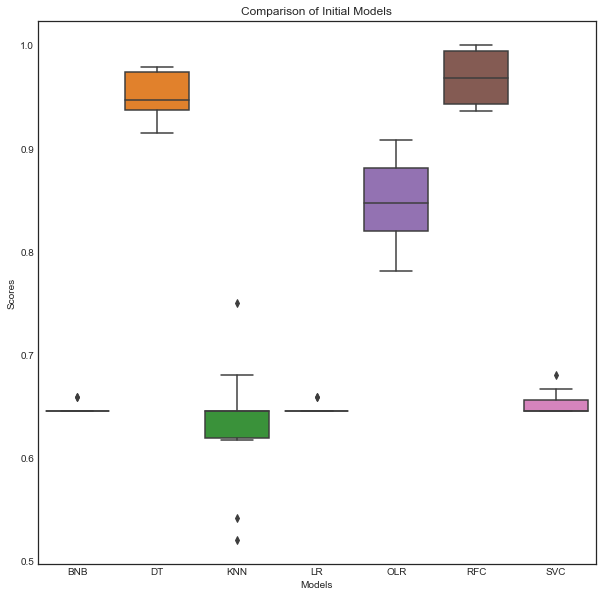

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=init_models, ax=ax)
im.set_title('Comparison of Initial Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

In [32]:
#Moving forward with Decision Tree, Linear Regression, and Random Forest due to performance
#Optimizing models using GridSearchCV
#Linear Regression will be our descriptive model
init_model2 = pd.DataFrame({'RFC': rfc_init_cvs,
                            'DT': dt_init_cvs,
                            'OLR': olr_init_cvs})

#Optimizing Random Forest
parameters = {}
parameters['criterion'] = ['entropy','gini']
parameters['max_depth'] = [3,4,5,6,7,8]
parameters['n_estimators'] = [5,10,20,30]

gsc_rfc = GridSearchCV(rfc_init, parameters, cv=3, verbose=1)
gsc_rfc.fit(X_train, y_train)
print(gsc_rfc.best_params_, gsc_rfc.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 20} 0.9790794979079498


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    4.1s finished


In [33]:
#Optimized model with Random Forest Classifier
rfc_opt = ensemble.RandomForestClassifier(n_estimators=20,
                                           criterion='entropy',
                                           max_depth=3)
rfc_opt.fit(X_train, y_train)
rfc_opt_cvs = cross_val_score(rfc_opt, X_train, y_train, cv=10)

In [48]:
#Optimizing Decision Tree
parameters_dt = {}
parameters_dt['criterion'] = ['entropy','gini']
parameters_dt['max_depth'] = [3,4,5,6,7,8,10,20,30]

gsc_dt = GridSearchCV(dt_init, parameters_dt, cv=3, verbose=1)
gsc_dt.fit(X_train, y_train)
print(gsc_dt.best_params_, gsc_dt.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'criterion': 'entropy', 'max_depth': 10} 0.9623430962343096


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.2s finished


In [49]:
dt_opt = tree.DecisionTreeClassifier(criterion='entropy',
                                     max_depth=10)
dt_opt.fit(X_train, y_train)
dt_opt_cvs = cross_val_score(dt_opt, X_train, y_train, cv=10)

In [53]:
opt_models = pd.DataFrame({'RFC': rfc_opt_cvs,
                           'DT': dt_opt_cvs,
                           'OLR': olr_init_cvs})

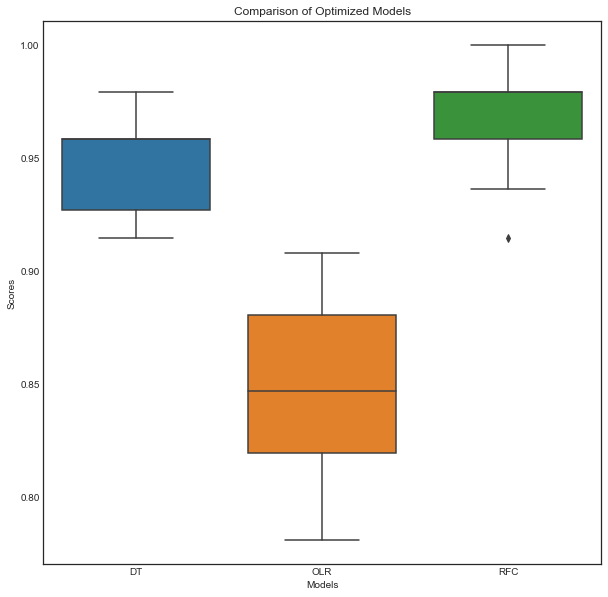

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=opt_models, ax=ax)
im.set_title('Comparison of Optimized Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

In [56]:
#Models are performing very strongly, but how do they do with predicting desired outcome?
#Decision Tree
cm_opt_dt = confusion_matrix(dt_opt.predict(X_train), y_train)
print('We correctly predicted malignant masses {0:.2f}% of the time with DT.'.format(
    (cm_opt_dt[1][1])/sum(cm_opt_dt[1])*100))

#Random Forest
cm_opt_rfc = confusion_matrix(rfc_opt.predict(X_train), y_train)
print('We correctly predicted malignant masses {0:.2f}% of the time with RFC.'.format(
    (cm_opt_rfc[1][1])/sum(cm_opt_rfc[1])*100))

#Decision Tree is still performing better at correctly predicting malignant masses

We correctly predicted malignant masses 100.00% of the time with DT.
We correctly predicted malignant masses 96.53% of the time with RFC.


In [45]:
print(X_train.columns)

Index(['Sample_id', 'Clump_thick', 'Uni_cell_size', 'Uni_cell_shape',
       'Marg_adhesion', 'Epi_cell_size', 'Nuclei_bare', 'Chromatin_bland',
       'Nucleoli_norm', 'Mitoses'],
      dtype='object')


In [46]:
rfe = RFE(olr, 3)
rfe.fit(X_train, y_train)
rfe.ranking_

NameError: name 'RFE' is not defined

In [47]:
#Most important features for determining cancer are Clump Thickness, Uniformity Cell Shape,
#and Bare Nuclei